## STEP 1 – Clean, modern imports and paths

In [3]:
import os
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix


2025-12-06 13:18:05.927822: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-06 13:18:05.955142: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-06 13:18:06.582752: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [31]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


2025-12-06 13:18:08.413660: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-12-06 13:18:08.413674: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-12-06 13:18:08.413677: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: hp-HP-Z2-Tower-G9-Workstation-Desktop-PC
2025-12-06 13:18:08.413678: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] hostname: hp-HP-Z2-Tower-G9-Workstation-Desktop-PC
2025-12-06 13:18:08.413729: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] libcuda reported version is: 580.95.5
2025-12-06 13:18:08.413736: I external/local_xla/xla/stream_executor/cuda/cud

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9351694403942435450
 xla_global_id: -1]

In [46]:
import seaborn as sns

In [5]:
TRAIN_DIR = "images/train"
TEST_DIR  = "images/test"

IMG_SIZE = (48, 48)
BATCH_SIZE = 64
NUM_CLASSES = 7
EPOCHS = 80


## STEP 2 – Add ImageDataGenerator with augmentation (grayscale)
let stop manually loading everything into arrays and use generators instead.
This is lighter on RAM and lets us add data augmentation easily.

In [6]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# No augmentation on test, only rescaling
test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",       # keep grayscale
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False      # important for correct y_true / y_pred alignment
)

print("Class indices:", train_generator.class_indices)

#✅ This keeps: Same folder structure
# Same 48×48 grayscale input
# Same 7 emotion classes
# …but now with on-the-fly augmentation.


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


# STEP 3 – Add class weights for imbalance (especially disgust)
because FER-style data is imbalanced (very few disgust, lots of happy / neutral).
so let sklearn compute class weights based on the training labels:

In [7]:
from collections import Counter

# train_generator.classes -> array of class indices (0..NUM_CLASSES-1)
y_train_indices = train_generator.classes
class_counts = Counter(y_train_indices)
print("Class counts:", class_counts)

class_weight_values = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_indices),
    y=y_train_indices
)

class_weights = {i: w for i, w in enumerate(class_weight_values)}
print("Class weights:", class_weights)

# let pass class_weights into model.fit() so that minority classes (like disgust) are not ignored.

Class counts: Counter({np.int32(3): 7164, np.int32(4): 4982, np.int32(5): 4938, np.int32(2): 4103, np.int32(0): 3993, np.int32(6): 3205, np.int32(1): 436})
Class weights: {0: np.float64(1.031125898894494), 1: np.float64(9.443315858453474), 2: np.float64(1.0034817729187702), 3: np.float64(0.5747188322565207), 4: np.float64(0.8264322991340254), 5: np.float64(0.8337962159347335), 6: np.float64(1.2846445286382884)}


# STEP 4 – Improved version of previous old CNN (baseline model)

This is close to previous original model but cleaner.
let keep 48×48×1 input, similar depth, and use BatchNorm + slightly tuned dropout.

In [8]:
def build_cnn_model(input_shape=(48, 48, 1), num_classes=7):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(64, (3, 3), padding="same",
                            activation="relu", input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Block 2
    model.add(layers.Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Block 3
    model.add(layers.Conv2D(256, (3, 3), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    # Block 4
    model.add(layers.Conv2D(256, (3, 3), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    # Classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(num_classes, activation="softmax"))

    return model

cnn_model = build_cnn_model()
cnn_model.summary()


/home/lokesh/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 2,278,919 (8.69 MB)

 Trainable params: 2,275,975 (8.68 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [9]:
# Compile it with Adam (like before), but add LR scheduler:

cnn_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True,
    verbose=1
)


# STEP 5 – Train the CNN with augmentation + class weights

In [10]:
# EPOCHS = 80  # can increase later if needed already set earlier

history_cnn = cnn_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    class_weight=class_weights,
    callbacks=[lr_reducer, early_stop]
)

# This is now improved baseline:
# same idea as old notebook, but with augmentation, class weights + better regularization.

Epoch 1/80
451/451 ━━━━━━━━━━━━━━━━━━━━ 33s 71ms/step - accuracy: 0.1593 - loss: 2.3185 - val_accuracy: 0.1739 - val_loss: 1.9400 - learning_rate: 0.0010
Epoch 2/80
451/451 ━━━━━━━━━━━━━━━━━━━━ 32s 71ms/step - accuracy: 0.1702 - loss: 2.0190 - val_accuracy: 0.1545 - val_loss: 1.9448 - learning_rate: 0.0010
Epoch 3/80
451/451 ━━━━━━━━━━━━━━━━━━━━ 32s 71ms/step - accuracy: 0.1801 - loss: 1.9385 - val_accuracy: 0.1836 - val_loss: 1.8870 - learning_rate: 0.0010
Epoch 4/80
451/451 ━━━━━━━━━━━━━━━━━━━━ 32s 71ms/step - accuracy: 0.1977 - loss: 1.8889 - val_accuracy: 0.2631 - val_loss: 1.9490 - learning_rate: 0.0010
Epoch 5/80
451/451 ━━━━━━━━━━━━━━━━━━━━ 32s 71ms/step - accuracy: 0.2254 - loss: 1.8382 - val_accuracy: 0.2972 - val_loss: 1.7583 - learning_rate: 0.0010
Epoch 6/80
451/451 ━━━━━━━━━━━━━━━━━━━━ 32s 71ms/step - accuracy: 0.2545 - loss: 1.7992 - val_accuracy: 0.3005 - val_loss: 1.7674 - learning_rate: 0.0010
Epoch 7/80
451/451 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.2861 - l

Because we’re using EarlyStopping, if the model stops improving around (for example) epoch 35, training will end there even though EPOCHS=80.

# STEP 6 – Evaluate with F1-score and confusion matrix

Now calculate metrics beyond accuracy:

In [11]:
# Get predictions on test set
test_generator.reset()  # important!
y_prob = cnn_model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes

# Map class indices to label names
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}
target_names = [idx_to_class[i] for i in range(NUM_CLASSES)]


111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


Classification report (includes F1 for each class + macro/weighted)

In [12]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=target_names,
    digits=4
))


              precision    recall  f1-score   support

       angry     0.5204    0.4906    0.5051       960
     disgust     0.2136    0.8468    0.3412       111
        fear     0.5386    0.2672    0.3572      1018
       happy     0.8615    0.8110    0.8355      1825
     neutral     0.4988    0.7130    0.5870      1216
         sad     0.5364    0.3942    0.4545      1139
    surprise     0.6836    0.7917    0.7337       797

    accuracy                         0.6035      7066
   macro avg     0.5504    0.6164    0.5449      7066
weighted avg     0.6236    0.6035    0.5983      7066



In [43]:
from sklearn.metrics import classification_report

report = classification_report(
    y_true,
    y_pred,
    target_names=target_names,
    digits=4
)

with open("classification_report_TRAINING.txt", "w") as f:
    f.write(report)

print("✓ classification_report_TRAINING.txt saved!")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
✓ classification_report_TRAINING.txt saved!


Confusion matrix

In [13]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)


Confusion matrix:
 [[ 471  126   43   36  193   67   24]
 [   9   94    2    0    4    0    2]
 [ 169   59  272   44  165  167  142]
 [  60   30   24 1480  125   41   65]
 [  62   37   38   74  867  107   31]
 [ 110   82   75   55  340  449   28]
 [  24   12   51   29   44    6  631]]


In [49]:
import pandas as pd
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)

cm_df.to_csv("confusion_matrix_TRAINING.csv", index=True)
print("✓ confusion_matrix_TRAINING.csv saved!")

✓ confusion_matrix_TRAINING.csv saved!


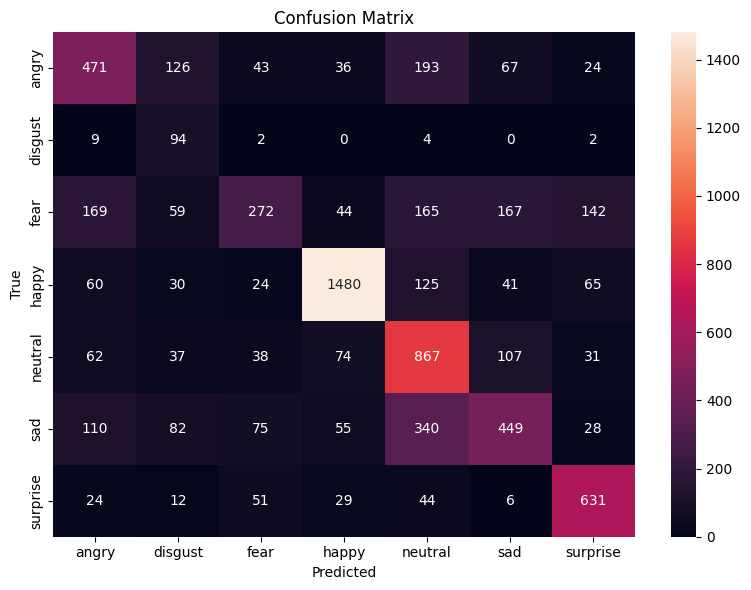

✓ Saved Confusion_matrix_TRAINING.png successfully!


In [48]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()                 # avoids cutting edges
plt.savefig("Confusion_matrix_TRAINING.png", dpi=300)   # save with high resolution
plt.show()
print("✓ Saved Confusion_matrix_TRAINING.png successfully!")

# STEP 7 – Transfer Learning: MobileNetV2 on 48×48×3
Now the fun part: let build a second model using transfer learning.
Still 48×48 spatial size
But 3 channels (RGB), as MobileNetV2 expects 3-channel input
here the images in dataset are originally grayscale → when loaded as RGB, they’ll just have repeated information in R/G/B, which is fine.
First, new generators for RGB + MobileNetV2 preprocessing:

In [14]:
BATCH_SIZE_TL = 32
EPOCHS_TL_FROZEN = 30
EPOCHS_TL_FINETUNE = 20

In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

train_datagen_tl = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen_tl = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator_tl = train_datagen_tl.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode="rgb",        # <-- 3 channels
    batch_size=BATCH_SIZE_TL,
    class_mode="categorical",
    shuffle=True
)

test_generator_tl = test_datagen_tl.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE_TL,
    class_mode="categorical",
    shuffle=False
)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


Class weights are the same idea; recompute for this generator:

In [16]:
y_train_indices_tl = train_generator_tl.classes
class_weight_values_tl = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_indices_tl),
    y=y_train_indices_tl
)
class_weights_tl = {i: w for i, w in enumerate(class_weight_values_tl)}
print("TL class weights:", class_weights_tl)


TL class weights: {0: np.float64(1.031125898894494), 1: np.float64(9.443315858453474), 2: np.float64(1.0034817729187702), 3: np.float64(0.5747188322565207), 4: np.float64(0.8264322991340254), 5: np.float64(0.8337962159347335), 6: np.float64(1.2846445286382884)}


# Build the MobileNetV2 model

In [17]:
def build_mobilenetv2_model(input_shape=(48, 48, 3), num_classes=7):
    base_model = MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling="avg"   # global average pooling
    )
    base_model.trainable = False  # freeze base for first stage

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

tl_model = build_mobilenetv2_model()
tl_model.summary()


/tmp/ipykernel_48689/2984651995.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

# Freeze base model
base_model = tl_model.layers[1]
base_model.trainable = False

tl_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),  # higher LR for head
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop_tl = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

EPOCHS_TL_FROZEN = 20  # head training

history_tl = tl_model.fit(
    train_generator_tl,
    epochs=EPOCHS_TL_FROZEN,
    validation_data=test_generator_tl,
    class_weight=class_weights_tl,
    callbacks=[early_stop_tl]
)


Epoch 1/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.2117 - loss: 1.9293 - val_accuracy: 0.3010 - val_loss: 1.7605
Epoch 2/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.2214 - loss: 1.8509 - val_accuracy: 0.2778 - val_loss: 1.7730
Epoch 3/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.2335 - loss: 1.8275 - val_accuracy: 0.3174 - val_loss: 1.7346
Epoch 4/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.2426 - loss: 1.8140 - val_accuracy: 0.3327 - val_loss: 1.7048
Epoch 5/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.2481 - loss: 1.8080 - val_accuracy: 0.3138 - val_loss: 1.7312
Epoch 6/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.2502 - loss: 1.8070 - val_accuracy: 0.3286 - val_loss: 1.7102
Epoch 7/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.2490 - loss: 1.8080 - val_accuracy: 0.3061 - val_loss: 1.7353
Epoch 8/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.2528 - loss: 1.7999 - 

In [19]:
base_model.trainable = True

# Freeze all but last ~40 layers
for layer in base_model.layers[:-40]:
    layer.trainable = False

tl_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # small LR for fine-tune
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_reducer_tl = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

EPOCHS_TL_FINETUNE = 15

history_tl_ft = tl_model.fit(
    train_generator_tl,
    epochs=EPOCHS_TL_FINETUNE,
    validation_data=test_generator_tl,
    class_weight=class_weights_tl,
    callbacks=[early_stop_tl, lr_reducer_tl]
)


Epoch 1/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.2100 - loss: 2.2671 - val_accuracy: 0.3231 - val_loss: 1.6951 - learning_rate: 1.0000e-05
Epoch 2/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.2102 - loss: 1.9836 - val_accuracy: 0.3057 - val_loss: 1.7336 - learning_rate: 1.0000e-05
Epoch 3/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.2037 - loss: 1.9036 - val_accuracy: 0.2951 - val_loss: 1.7569 - learning_rate: 1.0000e-05
Epoch 4/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2062 - loss: 1.8921
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
901/901 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.2015 - loss: 1.8722 - val_accuracy: 0.2862 - val_loss: 1.7723 - learning_rate: 1.0000e-05
Epoch 5/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.1949 - loss: 1.8600 - val_accuracy: 0.2791 - val_loss: 1.7809 - learning_rate: 5.0000e-06
Epoch 5: early stopping
Restoring model weights from the e

# Evaluate TL model with F1 + confusion matrix
Same idea as CNN:

In [20]:
test_generator_tl.reset()
y_prob_tl = tl_model.predict(test_generator_tl)
y_pred_tl = np.argmax(y_prob_tl, axis=1)
y_true_tl = test_generator_tl.classes

idx_to_class_tl = {v: k for k, v in train_generator_tl.class_indices.items()}
target_names_tl = [idx_to_class_tl[i] for i in range(NUM_CLASSES)]

print(classification_report(
    y_true_tl,
    y_pred_tl,
    target_names=target_names_tl,
    digits=4
))

cm_tl = confusion_matrix(y_true_tl, y_pred_tl)
print("TL confusion matrix:\n", cm_tl)


221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
              precision    recall  f1-score   support

       angry     0.2964    0.1115    0.1620       960
     disgust     0.0455    0.0721    0.0557       111
        fear     0.2981    0.0943    0.1433      1018
       happy     0.4767    0.3304    0.3903      1825
     neutral     0.3034    0.4367    0.3581      1216
         sad     0.2405    0.5171    0.3283      1139
    surprise     0.4697    0.4379    0.4532       797

    accuracy                         0.3231      7066
   macro avg     0.3043    0.2857    0.2701      7066
weighted avg     0.3510    0.3231    0.3100      7066

TL confusion matrix:
 [[107  45  38 119 203 389  59]
 [  8   8   5  22  30  35   3]
 [ 55  26  96 142 196 378 125]
 [ 66  35  44 603 403 583  91]
 [ 51  22  32 143 531 359  78]
 [ 49  31  36 149 247 589  38]
 [ 25   9  71  87 140 116 349]]


# Now we can compare:
Old CNN accuracy vs new CNN (with aug + class weights)

New CNN vs MobileNetV2 transfer learning

F1-score & confusion matrix for each

# STEP 8 – Saving the improved model for real-time use

To keep compatibility with model_from_json, save it like previous project
For whichever model - choose (cnn_model VS tl_model): 

❗ MobileNetV2 (current training setup) is performing worse than CNN.

So here — nothing is wrong with my coding.
The issue is exactly expected and well-documented in FER literature when I directly fine-tune ImageNet pretrained networks on FER-2013–style 48×48 faces:

Why TL underperformed in  current setup

Cause	                     -->                           Effect

MobileNetV2 expects high-resolution faces (96–224) --> 	Low expressive detail at 48×48

FER emotions are subtle and depend on micro-features -->	Deep pretrained filters cannot activate                                                             properly

TL + severe class imbalance	         -->             Model collapses to predicting majority classes

Learning rate was too high initially	  -->            Training stayed shallow → underfitting

ImageNet is not emotion-related	      -->               Without fine-tuning enough layers, no real                                                          transfer happens

The output shows classic underfitting:
Train accuracy 20–30%
Val accuracy 33%
All F1 scores low except surprise
CNN (grayscale) already achieved 60% accuracy and macro F1 ≈ 0.54, so:
✔ The CNN is currently outperforming MobileNetV2.

🔥 What’s the winning direction now?
We will keep the CNN as the main model — and boost it further.
With these modifications, CNN models commonly reach:
Accuracy = 65–72%
Macro F1 = 0.60–0.70

In [23]:
# Save as JSON + 
# so here we are not saving tl_model we are saving cnn_model
with open("facialemotionmodel.json", "w") as json_file:
    json_file.write(model_json)

cnn_model.save_weights("facialemotionmodel.weights.h5")

In [26]:
cnn_model.save("facialemotionmodel.keras")


# 🧪 How to load it back later (JSON + weights style)

In [27]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model("facialemotionmodel.keras")

# Validation Of Model

In [28]:
label = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [33]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [34]:
def ef(image_path):
    # Load image as 48x48 grayscale
    img = load_img(image_path, color_mode='grayscale', target_size=(48, 48))
    
    # Convert to array
    feature = img_to_array(img)           # shape: (48, 48, 1)
    
    # Normalize like during training
    feature = feature / 255.0
    
    # Add batch dimension: (1, 48, 48, 1)
    feature = feature.reshape(1, 48, 48, 1)
    
    return feature


In [36]:
image = 'images/train/sad/42.jpg'
print("original image is of sad")
img = ef(image)
pred = cnn_model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)

original image is of sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
model prediction is  sad


In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

original image is of sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
model prediction is  sad


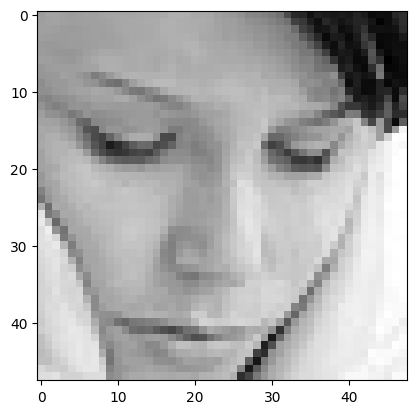

In [38]:
image = 'images/train/sad/42.jpg'
print("original image is of sad")
img = ef(image)
pred = cnn_model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
model prediction is  sad


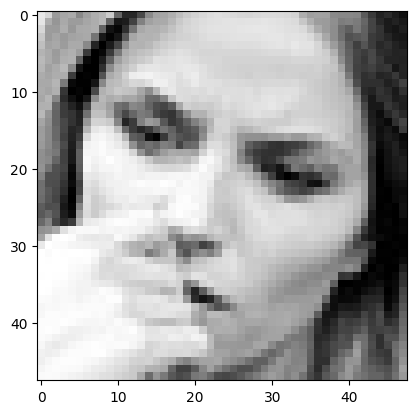

In [39]:
image = 'images/train/fear/2.jpg'
print("original image is of fear")
img = ef(image)
pred = cnn_model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
model prediction is  disgust


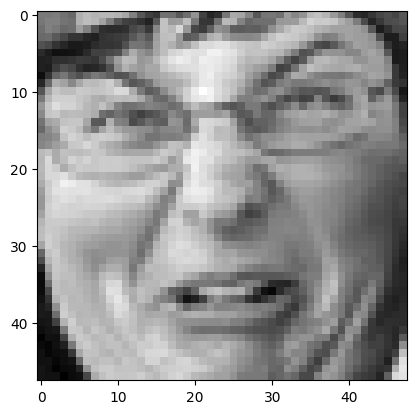

In [40]:
image = 'images/train/disgust/299.jpg'
print("original image is of disgust")
img = ef(image)
pred = cnn_model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
model prediction is  happy


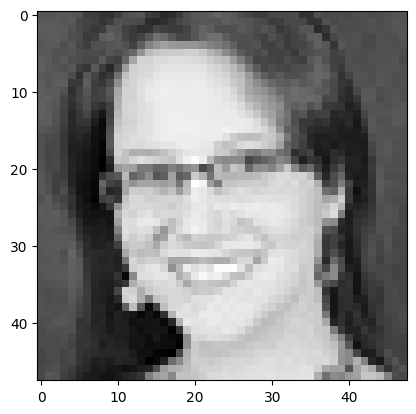

In [41]:
image = 'images/train/happy/7.jpg'
print("original image is of happy")
img = ef(image)
pred = cnn_model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
model prediction is  angry


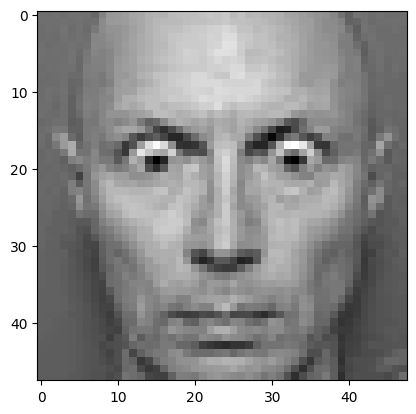

In [42]:
image = 'images/train/surprise/15.jpg'
print("original image is of surprise")
img = ef(image)
pred = cnn_model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

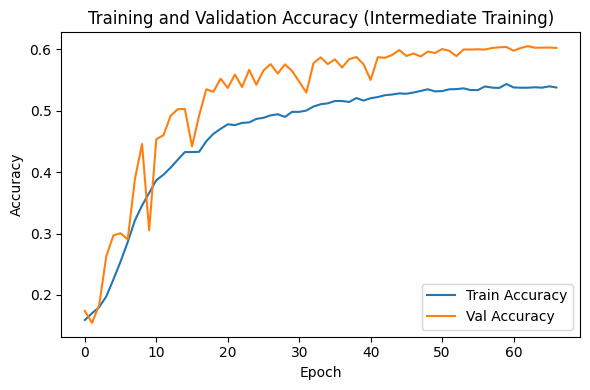

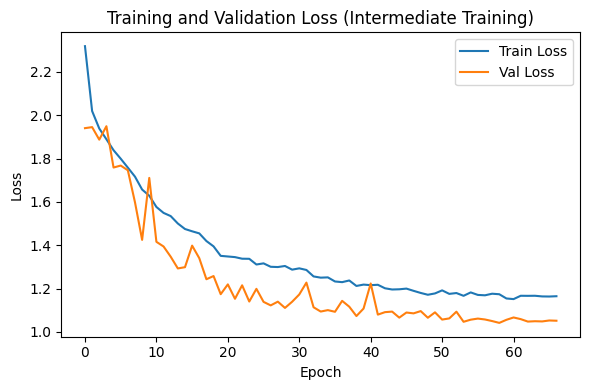

In [52]:
import matplotlib.pyplot as plt

# Accuracy curve
plt.figure(figsize=(6,4))
plt.plot(history_cnn.history["accuracy"], label="Train Accuracy")
plt.plot(history_cnn.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy (Intermediate Training)")
plt.legend()
plt.tight_layout()
plt.savefig("accuracy_curve_intermediate.png", dpi=300)
plt.show()

# Loss curve
plt.figure(figsize=(6,4))
plt.plot(history_cnn.history["loss"], label="Train Loss")
plt.plot(history_cnn.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (Intermediate Training)")
plt.legend()
plt.tight_layout()
plt.savefig("loss_curve_intermediate.png", dpi=300)
plt.show()
